In [1]:
import gc
import os
import nltk
import tqdm
import numpy as np
import pandas as pd
import string
import keras
import keras.backend as K
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eshanka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, LeakyReLU
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

In [3]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.3


Setting up parameter globals

In [4]:
gru_len = 256
Routings = 5
Num_capsule = 2
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

batch_size = 128
recurrent_units = 64
dropout_rate = 0.3 
dense_size = 20
sentences_length = 50
fold_count = 10
max_features = 20000
maxlen = 1000
embed_size = 256

Non-linear activation fucntion for capsule layer

In [5]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

Generating the capsule network algorithm with slight tweaks to optimize with the dataset


In [7]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # Expand the input in axis=1, tile in that axis to num_capsule, and 
        # expands another axis at the end to prepare the multiplication with W.
        #  inputs.shape=[None, input_num_capsule, input_dim_capsule]
        #  inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        #  inputs_tiled.shape=[None, num_capsule, input_num_capsule, 
        #                            input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(inputs, 1)
        inputs_tiled  = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])
        inputs_tiled  = tf.expand_dims(inputs_tiled, 4)

        # Compute `W * inputs` by scanning inputs_tiled on dimension 0 (map_fn).
        # - Use matmul (without transposing any element). Note the order!
        # Thus:
        #  x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        #  W.shape=[num_capsule, input_num_capsule, dim_capsule,input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1]-> 
        #              [dim_capsule, 1].
        #  inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
        
        inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)     

        # Begin: Routing algorithm ----------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        #  b.shape = [None, self.num_capsule, self.input_num_capsule, 1, 1].
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule, 
                            self.input_num_capsule, 1, 1])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # Apply softmax to the axis with `num_capsule`
            #  c.shape=[batch_size, num_capsule, input_num_capsule, 1, 1]
            c = layers.Softmax(axis=1)(b)

            # Compute the weighted sum of all the predicted output vectors.
            #  c.shape =  [batch_size, num_capsule, input_num_capsule, 1, 1]
            #  inputs_hat.shape=[None, num_capsule, input_num_capsule,dim_capsule,1]
            # The function `multiply` will broadcast axis=3 in c to dim_capsule.
            #  outputs.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
            # Then sum along the input_num_capsule
            #  outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
            # Then apply squash along the dim_capsule
            outputs = tf.multiply(c, inputs_hat)
            outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
            outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]

            if i < self.routings - 1:
                # Update the prior b.
                #  outputs.shape =  [None, num_capsule, 1, dim_capsule, 1]
                #  inputs_hat.shape=[None,num_capsule,input_num_capsule,dim_capsule,1]
                # Multiply the outputs with the weighted_inputs (inputs_hat) and add  
                # it to the prior b.  
                outputs_tiled = tf.tile(outputs, [1, 1, self.input_num_capsule, 1, 1])
                agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
                b = tf.add(b, agreement)

        # End: Routing algorithm ------------------------------------------------#
        # Squeeze the outputs to remove useless axis:
        #  From  --> outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
        #  To    --> outputs.shape=[None, num_capsule,    dim_capsule]
        outputs = tf.squeeze(outputs, [2, 4])
        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Tokenization

In [8]:
def rmv_acc(string_1):

    string_1 = string_1.replace("ç", "c")
    string_1 = string_1.replace("Ç", "C")
    string_1 = string_1.replace("à", "a")
    string_1 = string_1.replace("Ä", "A")
    string_1 = string_1.replace("ä", "a")
    string_1 = string_1.replace("À", "A")
    string_1 = string_1.replace("Â", "A")
    string_1 = string_1.replace("â", "a")
    string_1 = string_1.replace("é", "e")
    string_1 = string_1.replace("è", "e")
    string_1 = string_1.replace("É", "E")
    string_1 = string_1.replace("È", "E")
    string_1 = string_1.replace("Ë", "E")
    string_1 = string_1.replace("ë", "e")
    string_1 = string_1.replace("Ê", "E")
    string_1 = string_1.replace("ê", "e")
    string_1 = string_1.replace("û", "u")
    string_1 = string_1.replace("Û", "U")
    string_1 = string_1.replace("ü", "u")
    string_1 = string_1.replace("Ü", "U")
    string_1 = string_1.replace("ï", "i")
    string_1 = string_1.replace("Ï", "I")
    string_1 = string_1.replace("î", "i")
    string_1 = string_1.replace("Î", "I")
    string_1 = string_1.replace("Ô", "O")
    string_1 = string_1.replace("ô", "o")
    string_1 = string_1.replace("Ö", "O")
    string_1 = string_1.replace("ö", "o")
    string_1 = string_1.replace("Ù", "U")
    string_1 = string_1.replace("ù", "u")
    string_1 = string_1.replace("ÿ", "y")
    string_1 = string_1.replace("æ", "ae")
    string_1 = string_1.replace("_", " ")
    string_1 = string_1.replace("\n", "")

    return string_1

Reading dataset and Tokenizing the host urls

In [9]:
dframe = pd.read_csv('Datasets/dga_data.csv', sep = ',')
dframe = pd.DataFrame(dframe)
df = dframe[["host","isDGA"]]
domains = df['host'].apply(lambda x: rmv_acc(x))
labels = df['isDGA']

In [10]:
all_letters = set(' '.join([str(i) for i in domains]))
all_letters.add("END")
len_letters = len(all_letters)
char_map = {v: k for k, v in enumerate(all_letters)}

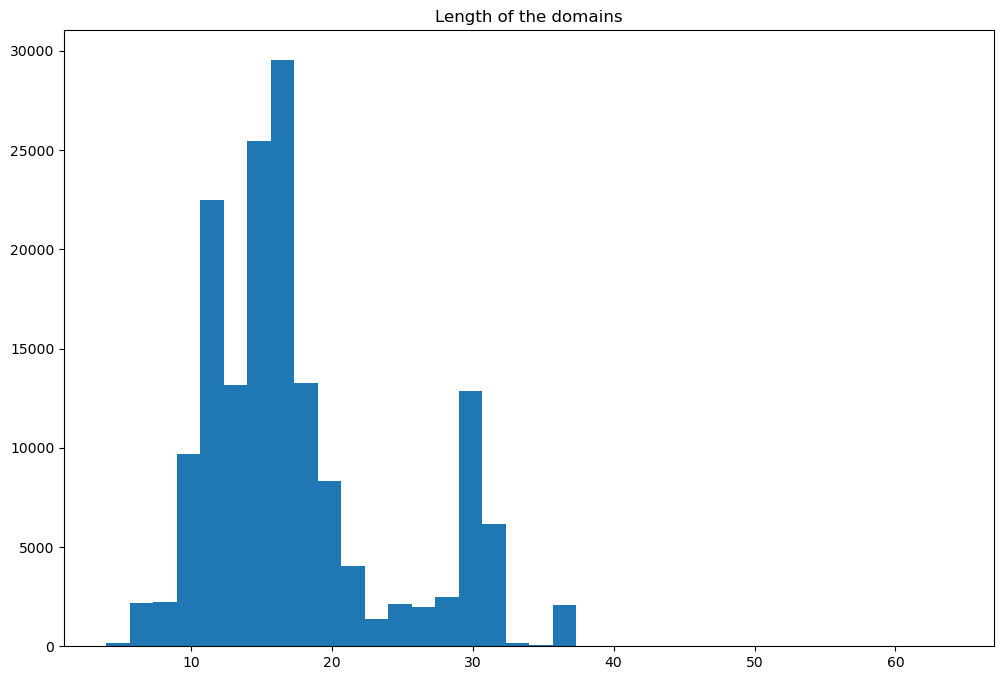

In [11]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in domains], bins=36)
plt.title("Length of the domains")
plt.show()

Embedding the dataset in a character level

In [12]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_letters)
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:sentences_length] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_map[j]) for j in str(i)]
        for k in range(0,sentences_length - len(str(i))):
            tmp.append(set_flag(char_map["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(domains.values)

def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'dga':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(labels)

Spliting training and testing values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Casting train and test lists into numpy arrays of type float

In [14]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


In [15]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape
#print(len_letters)

((107200, 50, 40), (107200, 2), (52800, 50, 40), (52800, 2))

DL model

In [16]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size):
    inputs = Input(shape=(sequence_length,len_letters,))
    bi = Bidirectional(GRU(gru_len, activation='relu', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True),backward_layer=GRU(gru_len, return_sequences=True, go_backwards=True))(inputs)
    capsule = CapsuleLayer(num_capsule=Num_capsule, dim_capsule=Dim_capsule)(bi)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_rate)(capsule)
    capsule = Dense(dense_size, activation='relu')(capsule)
    capsule = Flatten()(capsule)
    output = Dense(2, activity_regularizer=l2(0.002), activation='sigmoid')(capsule)
    model = Model(inputs=inputs, outputs=output, name="CapsDGA")
    return model

In [42]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size): 
    inputs = Input(shape=(sequence_length,))
    embed_layer = Embedding(max_features,
                                embed_size,
                                input_length=sequence_length)(inputs)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x = Bidirectional(GRU(gru_len,
                        activation='relu',
                        dropout=dropout_p,
                        recurrent_dropout=dropout_p,
                        return_sequences=True))(embed_layer)
    capsule = CapsuleLayer(num_capsule=Num_capsule, dim_capsule=Dim_capsule,)(x)

    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    capsule = LeakyReLU()(capsule)

    x = Flatten()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=predictions, name="CapsDGA")
    return model

In [27]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(512, return_sequences=True), backward_layer=LSTM(512, return_sequences=True, go_backwards=True), input_shape=(sentences_length,len_letters)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dropout(0.2))
    model.add(Dense(2, activity_regularizer=l2(0.002)))
    model.add(Activation('softmax'))
    return model

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Monitoring and model saving

In [17]:
#callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_9.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
# batch_size = 256
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, verbose=1, validation_data =(X_test, y_test), callbacks=[mc, reduce_lr_acc])

Getting the model object with the layers loaded in and getting the summary on it

In [18]:
dgaModel = get_model(sentences_length, len_letters, dropout_rate, dense_size)
dgaModel.summary()

Model: "CapsDGA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 40)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 512)           457728    
_________________________________________________________________
capsule_layer (CapsuleLayer) (None, 2, 16)             819200    
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0   

To get an idea on the models inputs and outputs

In [19]:
[print(i.shape, i.dtype) for i in dgaModel.inputs]
[print(o.shape, o.dtype) for o in dgaModel.outputs]
[print(l.name, l.input_shape, l.dtype) for l in dgaModel.layers]

(None, 50, 40) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
input_1 [(None, 50, 40)] float32
bidirectional (None, 50, 40) float32
capsule_layer (None, 50, 512) float32
flatten (None, 2, 16) float32
dropout (None, 32) float32
dense (None, 32) float32
flatten_1 (None, 20) float32
dense_1 (None, 20) float32


[None, None, None, None, None, None, None, None]

Compiling and fitting model

In [20]:
optimizer = Adam(learning_rate=0.003)
dgaModel.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [62]:
print("Starting to train models...")
dgaModel.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=20, verbose = 1, callbacks=[mc, reduce_lr_acc])

Starting to train models...
Epoch 1/20
 45/838 [>.............................] - ETA: 7:52 - loss: 0.4055 - accuracy: 0.8325

KeyboardInterrupt: 